In [1]:
from astropy.table import Table
import pandas as pd
from gaiaxpy import calibrate
from gaiaxpy import convert
import time
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import yaml
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from scipy.ndimage import gaussian_filter1d
import sys

In [2]:
def sycall(comand):
    import os
    linp=comand
    os.system(comand)


def retrive_gaia_star(gaiaID,gaia_dir=''):
    import os.path as ptt
    if ptt.exists(gaia_dir+'/gaia_spec_'+str(gaiaID)+'.csv') == True:
        data1 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+".csv", format="csv")
        data2 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+"_sampling.csv", format="csv")
        flux = np.array(list(data1["flux"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
        wave = np.array(list(data2["pos"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
    else:
        if ptt.exists(gaia_dir+'/XP_'+str(gaiaID)+'_RAW.csv') == True:
            f = gaia_dir+'/XP_'+str(gaiaID)+'_RAW.csv'
            df = pd.read_csv(f) 
            calibrated_spectra, _ = calibrate(df)
            calibrated_spectra, _ = calibrate(f, output_path=gaia_dir, output_file='gaia_spec_'+str(gaiaID), output_format='csv')
            data1 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+".csv", format="csv")
            data2 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+"_sampling.csv", format="csv")
            flux = np.array(list(data1["flux"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
            wave = np.array(list(data2["pos"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
        else:
            call='curl -k -b cookies-datalink.txt "https://gea.esac.esa.int/data-server/data?RETRIEVAL_TYPE=XP_CONTINUOUS&ID=Gaia+DR3+'+str(gaiaID)+'&format=CSV&DATA_STRUCTURE=RAW" > '+gaia_dir+'/XP_'+str(gaiaID)+'_RAW.csv'
            sycall(call)
            time.sleep(2)
            f = gaia_dir+'/XP_'+str(gaiaID)+'_RAW.csv'
            df = pd.read_csv(f) 
            calibrated_spectra, _ = calibrate(df)
            calibrated_spectra, _ = calibrate(f, output_path=gaia_dir, output_file='gaia_spec_'+str(gaiaID), output_format='csv')
            data1 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+".csv", format="csv")
            data2 = Table.read(gaia_dir+"/gaia_spec_"+str(gaiaID)+"_sampling.csv", format="csv")
            flux = np.array(list(data1["flux"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
            wave = np.array(list(data2["pos"][0].replace("(", "").replace(")", "").split(",")), dtype=float)
    wave=wave*1e1
    flux=flux*1e2#1e7*1e-1*1e-4        
    return flux,wave

def read_airmass(file_name,dir='./'):
    wave=[]
    ext=[]
    f=open(file_name,'r')
    for line in f:
        data=list(line.replace('\n','').split(' '))
        wave.extend([float(data[0])])
        ext.extend([float(data[1])])
    wave=np.array(wave)
    ext=np.array(ext)
    nt=np.where(ext < 1)[0]
    wave=wave[nt]
    ext=ext[nt]
    return wave,ext

In [3]:
def retrive_lvm_rawstd(expnum,redux_dir='',aperdir='',aptc=False,mjd='0000',redux_ver='0.1.1.dev0/1111/',basename='lvmCFrame-NAME.fits',path_lvmcore='',spid=0,fibid=[-1],cmid='b'):
    file=path_lvmcore+'/metrology/lvm_fiducial_fibermap.yaml'
    f=open(file,'r')
    fiber_map = yaml.safe_load(f)
    fiber_map=fiber_map['fibers']
    Std_n=[]
    Std_id=[]
    for i in range(0, len(fiber_map)):
        if 'standard' in fiber_map[i][4]:
            Std_n.extend([str(fiber_map[i][11])])
            Std_id.extend([str(fiber_map[i][0])])
    #i=0
    #if i == 0:
    try:
        file=redux_dir+'/'+redux_ver+'/'+mjd+'/'+basename.replace('NAME',str(expnum))
        print(file)
        [rss, hdr0]=fits.getdata(file,'FLUX', header=True)
        hdr1=fits.getheader(file,0)
        crpix=hdr0["CRPIX1"]
        cdelt=hdr0["CDELT1"]
        crval=hdr0["CRVAL1"]    
        mod=1944
    except:
        file=redux_dir+'/'+redux_ver+'/'+mjd+'/ancillary/'+basename.replace('NAME',str(expnum)).replace('SPID',cmid+str(spid))
        [rss, hdr1]=fits.getdata(file,0, header=True)
        if aptc:
            filec=aperdir+'/lvm-apercorr-SPID.fits'.replace('SPID',cmid+str(spid))
            [rssc, hdrt]=fits.getdata(filec,0, header=True)
            #crpix=hdrt["CRPIX1"]
            #cdelt=hdrt["CDELT1"]
            #crval=hdrt["CRVAL1"]
            nxa,nya=rssc.shape 
            #wave_a=crval+cdelt*(np.arange(ny)+1-crpix) 
            #rss=rss*rssc
        crpix=hdr1["CRPIX1"]
        cdelt=hdr1["CDELT1"]
        crval=hdr1["CRVAL1"]
        mod=648
    nx,ny=rss.shape    
    if mod == 648 and aptc:
        if ny > nya:
            rss=rss[:,0:nya]
            ny=nya
        if ny < nya:
            rssc=rssc[:,0:ny]
        print(ny,nya)
        rss=rss*rssc
    wave=crval+cdelt*(np.arange(ny)+1-crpix)  
    #if mod == 648:
    #    for i in range(0, nx):
    #        rss[i,:]=rss[i,:]*interp1d(wave_a,rssc[i,:],kind='linear',bounds_error=False)(wave)
    gaia_ID=[]
    gaia_T=[]
    gaia_N=[]
    gaia_ra=[]
    gaia_dec=[]
    gaia_T0=[]
    gaia_T1=[]
    gaia_exp=[]
    keys=list(hdr1.keys())
    for i in range(0, len(keys)):
        for j in range(1, 16):
            if "STD"+str(j)+"FIB" in keys[i]:
                gaia_N.extend([str(hdr1[keys[i]])])
            if "STD"+str(j)+"ACQ" in  keys[i]:
                gaia_T.extend([str(hdr1[keys[i]])])
            if "STD"+str(j)+"ID" in  keys[i]:
                gaia_ID.extend([str(hdr1[keys[i]])])
            if "STD"+str(j)+"RA" in  keys[i]:
                #gaia_ra.extend([str(hdr1[keys[i]])])
                gaia_ra.extend([str(hdr1['POSCIRA'])])
            if "STD"+str(j)+"DE" in  keys[i]:
                #gaia_dec.extend([str(hdr1[keys[i]])]) 
                gaia_dec.extend([str(hdr1['POSCIDE'])]) 
            if "STD"+str(j)+"T0" in  keys[i]:
                #gaia_T0.extend([str(hdr1[keys[i]])])
                gaia_T0.extend([str(hdr1['INTSTART'])])
            if "STD"+str(j)+"T1" in  keys[i]:
                gaia_T1.extend([str(hdr1[keys[i]])])        
            if "STD"+str(j)+"EXP" in  keys[i]:
                gaia_exp.extend([str(hdr1[keys[i]])])  
    gaiaF_ID=[]
    gaia_I=[]  
    gaia_Nf=[] 
    gaia_raf=[]
    gaia_decf=[]
    gaia_T0f=[]
    gaia_T1f=[]
    gaia_expf=[]   
    for i in range(0, 15):
        if "T" in  gaia_T[i]:
            gaiaF_ID.extend([gaia_ID[i]])
            gaia_I.extend([i])
            gaia_Nf.extend([gaia_N[i]])
            gaia_raf.extend([gaia_ra[i]])
            gaia_decf.extend([gaia_dec[i]])
            gaia_T0f.extend([gaia_T0[i]])
            gaia_T1f.extend([gaia_T1[i]])
            gaia_expf.extend([gaia_exp[i]])
    gaiaF_IDf=[]  
    gaia_If=[]
    gaiaF_Nf=[]
    gaiaF_raf=[]
    gaiaF_decf=[]
    gaiaF_T0f=[]
    gaiaF_T1f=[]
    gaiaF_expf=[]
    #print(gaia_Nf)
    for i in range(0, len(gaia_Nf)):
        for j in range(0, len(Std_n)):
            if gaia_Nf[i] == Std_n[j]:
                if spid > 0:
                    if spid == 1:
                        if int(Std_id[j]) < 649:
                            gaia_If.extend([(int(Std_id[j])-1) % mod])
                            gaiaF_IDf.extend([gaiaF_ID[i]])
                            gaiaF_Nf.extend([gaia_Nf[i]])
                            gaiaF_raf.extend([gaia_raf[i]])
                            gaiaF_decf.extend([gaia_decf[i]])
                            gaiaF_T0f.extend([gaia_T0f[i]])
                            gaiaF_T1f.extend([gaia_T1f[i]]) 
                            gaiaF_expf.extend([gaia_expf[i]]) 
                    if spid == 2:
                        if int(Std_id[j]) > 648 and int(Std_id[j]) < 1297:
                            gaia_If.extend([(int(Std_id[j])-1) % mod])
                            gaiaF_IDf.extend([gaiaF_ID[i]])
                            gaiaF_Nf.extend([gaia_Nf[i]])
                            gaiaF_raf.extend([gaia_raf[i]])
                            gaiaF_decf.extend([gaia_decf[i]])
                            gaiaF_T0f.extend([gaia_T0f[i]])
                            gaiaF_T1f.extend([gaia_T1f[i]]) 
                            gaiaF_expf.extend([gaia_expf[i]])                             
                    if spid == 3:
                        if int(Std_id[j]) > 1296:
                            #print((int(Std_id[j])-1) % mod,int(Std_id[j])-1)
                            gaia_If.extend([(int(Std_id[j])-1) % mod])
                            gaiaF_IDf.extend([gaiaF_ID[i]])
                            gaiaF_Nf.extend([gaia_Nf[i]])    
                            gaiaF_raf.extend([gaia_raf[i]])
                            gaiaF_decf.extend([gaia_decf[i]])
                            gaiaF_T0f.extend([gaia_T0f[i]])
                            gaiaF_T1f.extend([gaia_T1f[i]]) 
                            gaiaF_expf.extend([gaia_expf[i]])             
                else:
                    gaia_If.extend([int(Std_id[j])-1])
                    gaiaF_IDf.extend([gaiaF_ID[i]])
                    gaiaF_Nf.extend([gaia_Nf[i]])
                    gaiaF_raf.extend([gaia_raf[i]])
                    gaiaF_decf.extend([gaia_decf[i]])
                    gaiaF_T0f.extend([gaia_T0f[i]])
                    gaiaF_T1f.extend([gaia_T1f[i]]) 
                    gaiaF_expf.extend([gaia_expf[i]]) 
    
    if len(fibid) > 1:
        gaia_If=fibid
        gaiaF_IDf=[]
        gaiaF_raf_t=[]
        gaiaF_decf_t=[]
        for i in range(0, len(fibid)):
            gaiaF_IDf.extend([6813658512058329344])#5010284310919786496])
            gaiaF_raf_t.extend([gaiaF_raf[0]])
            gaiaF_decf_t.extend([gaiaF_decf[0]])
        gaiaF_decf=gaiaF_decf_t
        gaiaF_raf=gaiaF_raf_t
    elif fibid[0] > -1:
        gaia_If[0]=fibid[0]#905
        gaiaF_IDf[0]=6813658512058329344#5010284310919786496
        #gaia_If=[fibid]
    lco=EarthLocation(lat=-29.008999964*u.deg, lon=-70.688663912*u.deg, height=2800*u.m)   
    airmass=np.zeros(len(gaiaF_raf))
    wave_ext,k_ext=read_airmass('LVM_LVM160_KLAM.dat')
    kext=interp1d(wave_ext,k_ext,kind='linear',bounds_error=False)(wave*1e10)
    for i in range(0, len(gaiaF_raf)):
        c=SkyCoord(float(gaiaF_raf[i]), float(gaiaF_decf[i]), unit="deg") 
        t=Time(gaiaF_T0f[0])
        #print(gaiaF_T0f[0])
        #print(lco)
        #print(c)
        stdT = c.transform_to(AltAz(obstime=t,location=lco))  
        airmass[i]=stdT.secz 
        rss[gaia_If[i],:]=10**(0.4*kext*airmass[i])*rss[gaia_If[i],:]/300.0#/float(gaiaF_expf[i])
    
    #print(gaiaF_raf[0],gaiaF_decf[0])
    #gaia_If=[126,162,512,513,553,884,989,1297,1345,1427,1826]
    #print(gaiaF_IDf,'b')        
    #print(gaiaF_Nf)
    #print(gaia_If)
    print('AIRMASS=',airmass[0])
    wave=wave*1e10
    #print(gaia_If)
    if len(fibid) > 1:
        gaia_spec=rss[gaia_If,:]
    else:
        gaia_spec=rss[gaia_If[0],:]
    #gaia_spec=np.nanmean(rss[[gaia_If[0]],:],axis=0)
    #print(gaia_spec)
    #print(gaia_If[0])
    #print(rss[gaia_If[0],:])
    gaia_spec=np.nanmean(gaia_spec,axis=0)
        
    #try:
    #    nt=np.where(rss[:,6750] > 0.5)[0]
    #    gaia_spec=np.nanmean(rss[nt,:],axis=0)#/float(hdr1["STD1EXP"])
    #except:
    #    nt=np.where(rss[:,1900] > 0.5)[0]
    #    gaia_spec=np.nanmean(rss[nt,:],axis=0)#/float(hdr1["STD1EXP"])
    #print(nt,"A")
    #nt=[126,162,512,513,553,884,989,1297,1345,1427,1725,1826]
    #print(rss[nt,:],'a',gaia_If[0],nt)
    #gaia_spec=np.nanmean(rss[nt,:],axis=0)
    #print(gaia_spec)
    return  gaia_spec,gaiaF_IDf,airmass,wave   	
        

/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60204/lvmCFrame-00005065.fits
AIRMASS= 1.1282330441871065


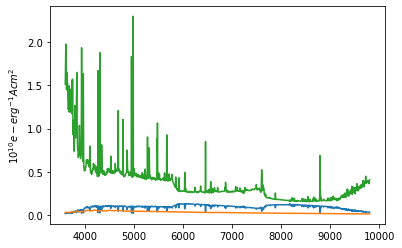

/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60204/lvmCFrame-00005068.fits
AIRMASS= 1.087692304502218


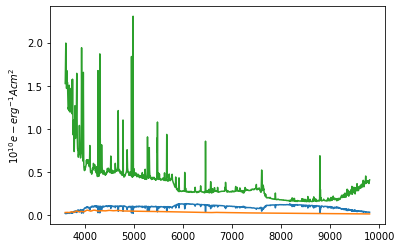

/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60204/lvmCFrame-00005071.fits
AIRMASS= 1.0561155829189706


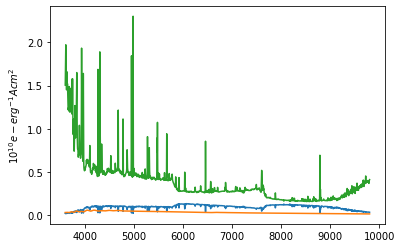

/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60204/lvmCFrame-00005074.fits
AIRMASS= 1.032857041391657


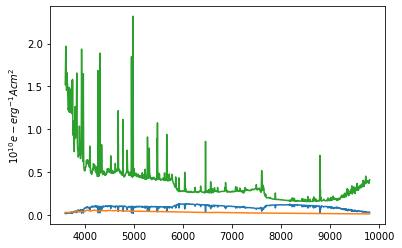

/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60204/lvmCFrame-00005077.fits
AIRMASS= 1.0161390168537348


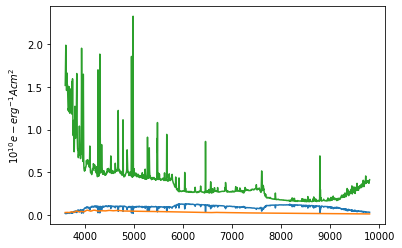

/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60204/lvmCFrame-00005080.fits
AIRMASS= 1.0078604723655495


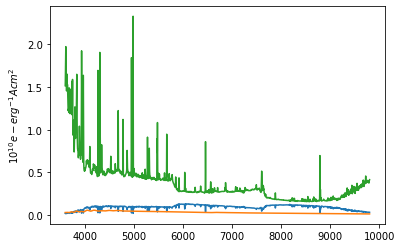

/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60204/lvmCFrame-00005083.fits
AIRMASS= 1.0062545593524244


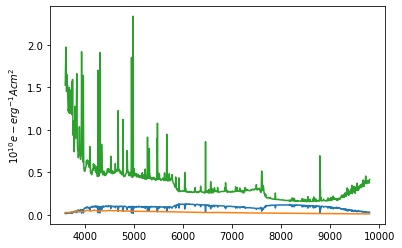

/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60204/lvmCFrame-00005086.fits
AIRMASS= 1.0117589247868795


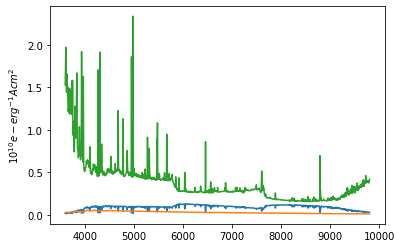

SystemExit: 

/home/hjibarram/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3259: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
import sys

#map_ifu('00004657',path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60200',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
#sys.exit()      
#[ 126  162  512  513  553  884  989 1297 1345 1427 1725 1826]
#[ 692  969  970  971  972  979 1411 1474 1663 1706]
fibid=[970,971,972,1474]
lvm_spec0,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00005065',fibid=[894,970,971,972], path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60204',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
flux,wave=retrive_gaia_star(gaiaF_ID[0],gaia_dir='gaia')
#print(gaiaF_ID,"C")
#try:
#    for i in range(0, len(gaiaF_ID)):
#        flux,wave=retrive_gaia_star(gaiaF_ID[i],gaia_dir='gaia')
#        flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
#        lvm_spec = gaussian_filter1d(lvm_spec0[i,:], 5)
#        plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
#        #plt.plot(wave1,flux_1)
#        plt.ylabel('e-/s')
#        plt.show()
#except:
a=0
if a==0:
   # print("DDD")
    lvm_spec = gaussian_filter1d(lvm_spec0, 5)
    plt.plot(wave1,lvm_spec)#[index,:])
    #plt.ylabel('e-/s')
    #plt.show()
    
    flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
    #plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
    plt.plot(wave1,flux_1)
 #   plt.ylabel('e-/s; erg/s/A/cm^2 ')
 #   plt.show
    
 #   flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
    plt.plot(wave1,flux_1/lvm_spec)#/flux_1)#[index,:])
    plt.ylabel('$10^{10}e- erg^{-1} A cm^2$')
    plt.show()

wave_fin=wave1
flux_A=flux_1/lvm_spec
    
lvm_spec0,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00005068',fibid=[894,970,971,972], path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60204',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
#try:
#    for i in range(0, len(gaiaF_ID)):
#        flux,wave=retrive_gaia_star(gaiaF_ID[i],gaia_dir='gaia')
#        flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
#        lvm_spec = gaussian_filter1d(lvm_spec0[i,:], 5)
#        plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
#        #plt.plot(wave1,flux_1)
#        plt.ylabel('e-/s')
#        plt.show()
#except:
   # print("RR")
if a==0:    
    lvm_spec = gaussian_filter1d(lvm_spec0, 5)
    plt.plot(wave1,lvm_spec)#[index,:])
#    plt.ylabel('e-/s')
#    plt.show()
    
    flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
 #   plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
    plt.plot(wave1,flux_1)
 #   plt.ylabel('e-/s; erg/s/A/cm^2 ')
 #   plt.show
    
 #   flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
    plt.plot(wave1,flux_1/lvm_spec)#/flux_1)#[index,:])
    plt.ylabel('$10^{10}e- erg^{-1} A cm^2$')
    plt.show()

    flux_B=interp1d(wave1,flux_1/lvm_spec,kind='linear',bounds_error=False)(wave_fin)

lvm_spec0,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00005071',fibid=[894,970,971,972], path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60204',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
#print(gaiaF_ID,"C")
try:
    for i in range(0, len(gaiaF_ID)):
        flux,wave=retrive_gaia_star(gaiaF_ID[i],gaia_dir='gaia')
        flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
        lvm_spec = gaussian_filter1d(lvm_spec0[i,:], 5)
        plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
        #plt.plot(wave1,flux_1)
        plt.ylabel('e-/s')
        plt.show()
except:
    lvm_spec = gaussian_filter1d(lvm_spec0, 5)
    plt.plot(wave1,lvm_spec)#[index,:])
    #plt.ylabel('e-/s')
    #plt.show()
    
    flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
 #   plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
    plt.plot(wave1,flux_1)
 #   plt.ylabel('e-/s; erg/s/A/cm^2 ')
 #   plt.show
    
 #   flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
    plt.plot(wave1,flux_1/lvm_spec)#/flux_1)#[index,:])
    plt.ylabel('$10^{10}e- erg^{-1} A cm^2$')
    plt.show()    
    flux_C=interp1d(wave1,flux_1/lvm_spec,kind='linear',bounds_error=False)(wave_fin)

lvm_spec0,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00005074',fibid=[894,970,971,972], path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60204',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
#print(gaiaF_ID,"C")
try:
    for i in range(0, len(gaiaF_ID)):
        flux,wave=retrive_gaia_star(gaiaF_ID[i],gaia_dir='gaia')
        flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
        lvm_spec = gaussian_filter1d(lvm_spec0[i,:], 5)
        plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
        #plt.plot(wave1,flux_1)
        plt.ylabel('e-/s')
        plt.show()
except:
    lvm_spec = gaussian_filter1d(lvm_spec0, 5)
    plt.plot(wave1,lvm_spec)#[index,:])
    #plt.ylabel('e-/s')
    #plt.show()
    
    flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
 #   plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
    plt.plot(wave1,flux_1)
 #   plt.ylabel('e-/s; erg/s/A/cm^2 ')
 #   plt.show
    
 #   flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
    plt.plot(wave1,flux_1/lvm_spec)#/flux_1)#[index,:])
    plt.ylabel('$10^{10}e- erg^{-1} A cm^2$')
    plt.show()  
    flux_D=interp1d(wave1,flux_1/lvm_spec,kind='linear',bounds_error=False)(wave_fin)
    
lvm_spec0,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00005077',fibid=[894,970,971,972], path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60204',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
#print(gaiaF_ID,"C")
try:
    for i in range(0, len(gaiaF_ID)):
        flux,wave=retrive_gaia_star(gaiaF_ID[i],gaia_dir='gaia')
        flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
        lvm_spec = gaussian_filter1d(lvm_spec0[i,:], 5)
        plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
        #plt.plot(wave1,flux_1)
        plt.ylabel('e-/s')
        plt.show()
except:
    lvm_spec = gaussian_filter1d(lvm_spec0, 5)
    plt.plot(wave1,lvm_spec)#[index,:])
    #plt.ylabel('e-/s')
    #plt.show()
    
    flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
 #   plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
    plt.plot(wave1,flux_1)
 #   plt.ylabel('e-/s; erg/s/A/cm^2 ')
 #   plt.show
    
 #   flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
    plt.plot(wave1,flux_1/lvm_spec)#/flux_1)#[index,:])
    plt.ylabel('$10^{10}e- erg^{-1} A cm^2$')
    plt.show()  
    flux_E=interp1d(wave1,flux_1/lvm_spec,kind='linear',bounds_error=False)(wave_fin)
    
lvm_spec0,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00005080',fibid=[894,970,971,972], path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60204',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
#print(gaiaF_ID,"C")
try:
    for i in range(0, len(gaiaF_ID)):
        flux,wave=retrive_gaia_star(gaiaF_ID[i],gaia_dir='gaia')
        flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
        lvm_spec = gaussian_filter1d(lvm_spec0[i,:], 5)
        plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
        #plt.plot(wave1,flux_1)
        plt.ylabel('e-/s')
        plt.show()
except:
    lvm_spec = gaussian_filter1d(lvm_spec0, 5)
    plt.plot(wave1,lvm_spec)#[index,:])
    #plt.ylabel('e-/s')
    #plt.show()
    
    flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
 #   plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
    plt.plot(wave1,flux_1)
 #   plt.ylabel('e-/s; erg/s/A/cm^2 ')
 #   plt.show
    
 #   flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
    plt.plot(wave1,flux_1/lvm_spec)#/flux_1)#[index,:])
    plt.ylabel('$10^{10}e- erg^{-1} A cm^2$')
    plt.show()  
    flux_F=interp1d(wave1,flux_1/lvm_spec,kind='linear',bounds_error=False)(wave_fin)

lvm_spec0,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00005083',fibid=[894,970,971,972], path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60204',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
#print(gaiaF_ID,"C")
try:
    for i in range(0, len(gaiaF_ID)):
        flux,wave=retrive_gaia_star(gaiaF_ID[i],gaia_dir='gaia')
        flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
        lvm_spec = gaussian_filter1d(lvm_spec0[i,:], 5)
        plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
        #plt.plot(wave1,flux_1)
        plt.ylabel('e-/s')
        plt.show()
except:
    lvm_spec = gaussian_filter1d(lvm_spec0, 5)
    plt.plot(wave1,lvm_spec)#[index,:])
    #plt.ylabel('e-/s')
    #plt.show()
    
    flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
 #   plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
    plt.plot(wave1,flux_1)
 #   plt.ylabel('e-/s; erg/s/A/cm^2 ')
 #   plt.show
    
 #   flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
    plt.plot(wave1,flux_1/lvm_spec)#/flux_1)#[index,:])
    plt.ylabel('$10^{10}e- erg^{-1} A cm^2$')
    plt.show() 
    flux_G=interp1d(wave1,flux_1/lvm_spec,kind='linear',bounds_error=False)(wave_fin)
    
lvm_spec0,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00005086',fibid=[894,970,971,972], path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60204',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
#print(gaiaF_ID,"C")
try:
    for i in range(0, len(gaiaF_ID)):
        flux,wave=retrive_gaia_star(gaiaF_ID[i],gaia_dir='gaia')
        flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
        lvm_spec = gaussian_filter1d(lvm_spec0[i,:], 5)
        plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
        #plt.plot(wave1,flux_1)
        plt.ylabel('e-/s')
        plt.show()
except:
    lvm_spec = gaussian_filter1d(lvm_spec0, 5)#120)
    plt.plot(wave1,lvm_spec)#[index,:])
    #plt.ylabel('e-/s')
    #plt.show()
    flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
    #plt.plot(wave1,lvm_spec)#/flux_1)#[index,:])
    plt.plot(wave1,flux_1)
    #plt.ylabel('e-/s; erg/s/A/cm^2 ')
    #plt.show
    
    #flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
    plt.plot(wave1,flux_1/lvm_spec)#/flux_1)#[index,:])
    plt.ylabel('$10^{10}e- erg^{-1} A cm^2$')
    plt.show() 
    flux_H=interp1d(wave1,flux_1/lvm_spec,kind='linear',bounds_error=False)(wave_fin)
    
#print(lvm_spec)
ft=open('sensitivity.csv','w')
ft.write('WAVE , VAL1 , VAL2 , VAL3 , VAL4 , VAL5 , VAL6 , VAL7 , VAL8\n')
for i in range(0, len(wave_fin)):
    line=str(wave_fin[i])+' , '+str(flux_A[i])+' , '+str(flux_B[i])+' , '+str(flux_C[i])
    line=line+' , '+str(flux_D[i])+' , '+str(flux_E[i])+' , '+str(flux_F[i])
    line=line+' , '+str(flux_G[i])+' , '+str(flux_H[i])+' \n'
    ft.write(line)
sys.exit()
#lvm_spec0,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00003900',fibid=905,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
#lvm_spec1,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00003900',fibid=910,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
#lvm_spec2,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00003900',fibid=917,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')
#lvm_spec2,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00003900',fibid=1360,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvmCFrame-NAME.fits')

#plt.plot(wave,flux*1e10)#*1e14)
#plt.plot(wave1,flux_n)
lvm_spec = gaussian_filter1d(lvm_spec0, 5)
plt.plot(wave1,lvm_spec/20)#[index,:])
plt.ylabel('Arbitrary scale')
plt.show()
sys.exit()

lvm_spec0,gaiaF_ID,airmass,wave0=retrive_lvm_rawstd('00003900',aperdir='apertures',aptc=False,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvm-hobject-SPID-NAME.fits',spid=1,cmid='b')
lvm_spec1,gaiaF_ID,airmass,wave1=retrive_lvm_rawstd('00003900',aperdir='apertures',aptc=False,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvm-hobject-SPID-NAME.fits',spid=2,cmid='b')
lvm_spec2,gaiaF_ID,airmass,wave2=retrive_lvm_rawstd('00003900',aperdir='apertures',aptc=False,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvm-hobject-SPID-NAME.fits',spid=3,cmid='b')
lvm_spec3,gaiaF_ID,airmass,wave3=retrive_lvm_rawstd('00003900',aperdir='apertures',aptc=False,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvm-hobject-SPID-NAME.fits',spid=1,cmid='r')
lvm_spec4,gaiaF_ID,airmass,wave4=retrive_lvm_rawstd('00003900',aperdir='apertures',aptc=False,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvm-hobject-SPID-NAME.fits',spid=2,cmid='r')
lvm_spec5,gaiaF_ID,airmass,wave5=retrive_lvm_rawstd('00003900',aperdir='apertures',aptc=False,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvm-hobject-SPID-NAME.fits',spid=3,cmid='r')
lvm_spec6,gaiaF_ID,airmass,wave6=retrive_lvm_rawstd('00003900',aperdir='apertures',aptc=False,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvm-hobject-SPID-NAME.fits',spid=1,cmid='z')
lvm_spec7,gaiaF_ID,airmass,wave7=retrive_lvm_rawstd('00003900',aperdir='apertures',aptc=False,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvm-hobject-SPID-NAME.fits',spid=2,cmid='z')
lvm_spec8,gaiaF_ID,airmass,wave8=retrive_lvm_rawstd('00003900',aperdir='apertures',aptc=False,path_lvmcore='/home/hjibarram/LVM/lvmcore',redux_dir='/media/hjibarram/D8TB/LVM/sas/sdsswork/lvm/spectro/redux',mjd='60184',redux_ver='0.1.1.dev0/1111',basename='lvm-hobject-SPID-NAME.fits',spid=3,cmid='z')
index=0
gaiaID=6813658512058329344
#flux,wave=retrive_gaia_star(gaiaF_ID[index],gaia_dir='gaia')
flux,wave=retrive_gaia_star(gaiaID,gaia_dir='gaia')
flux_0=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave0)
flux_1=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave1)
flux_2=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave2)
flux_3=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave3)
flux_4=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave4)
flux_5=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave5)
flux_6=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave6)
flux_7=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave7)
flux_8=interp1d(wave,flux*1e10,kind='linear',bounds_error=False)(wave8)


lvm_spec0 = gaussian_filter1d(lvm_spec0, 5)
lvm_spec1 = gaussian_filter1d(lvm_spec1, 5)
lvm_spec2 = gaussian_filter1d(lvm_spec2, 5)
lvm_spec3 = gaussian_filter1d(lvm_spec3, 5)
lvm_spec4 = gaussian_filter1d(lvm_spec4, 5)
lvm_spec5 = gaussian_filter1d(lvm_spec5, 5)
lvm_spec6 = gaussian_filter1d(lvm_spec6, 5)
lvm_spec7 = gaussian_filter1d(lvm_spec7, 5)
lvm_spec8 = gaussian_filter1d(lvm_spec8, 5)

plt.plot(wave,flux*1e10)#*1e14)
plt.plot(wave0,lvm_spec0)
plt.plot(wave1,lvm_spec1)
plt.plot(wave2,lvm_spec2)
plt.plot(wave3,lvm_spec3)
plt.plot(wave4,lvm_spec4)
plt.plot(wave5,lvm_spec5)
plt.plot(wave6,lvm_spec6)
plt.plot(wave7,lvm_spec7)
plt.plot(wave8,lvm_spec8)
plt.ylim(0,0.1)
plt.show()

plt.plot(wave0,lvm_spec0/flux_0)
plt.plot(wave1,lvm_spec1/flux_1)
plt.plot(wave2,lvm_spec2/flux_2)
plt.plot(wave3,lvm_spec3/flux_3)
plt.plot(wave4,lvm_spec4/flux_4)
plt.plot(wave5,lvm_spec5/flux_5)
plt.plot(wave6,lvm_spec6/flux_6)
plt.plot(wave7,lvm_spec7/flux_7)
plt.plot(wave8,lvm_spec8/flux_8)
plt.ylabel('$10^{10}e- erg^{-1} A cm^2$')
plt.ylim(0,5)
plt.show()
